### Retailer Ordering - System Dynamics Model with Machine Learning: Karthikeyan Sankaran

This is a toy example that illustrates the use of Simulation Modeling in conjunction with Supervised Machine Learning. This example was prepared for the Analytics Vidhya DataHack Summit 2018.

** 0. Loading the Relevant Libraries **
- PySD is the python library that is used to parse a Vensim model (one of the simulation modeling tools) and load into Python's namespace

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pysd

### Retailer Ordering Model

** This example is taken from the book 'System Dynamics Methods: A Quick Introduction' by Craig W.Kirkwood **

- Chapter 5 in the book is the model of a production distribution system (2 processes)
- Production Process: Shown in the top flowing to the right. This represents the flow of orders from the retailer.
- Distribution Process: Shown in the botton flowing to the left. This represents the flow of materials from the manufacturer
- As items are produced, the orders for these items are removed from the Factory Order Backlog, and the items are placed into Retail Inventory.

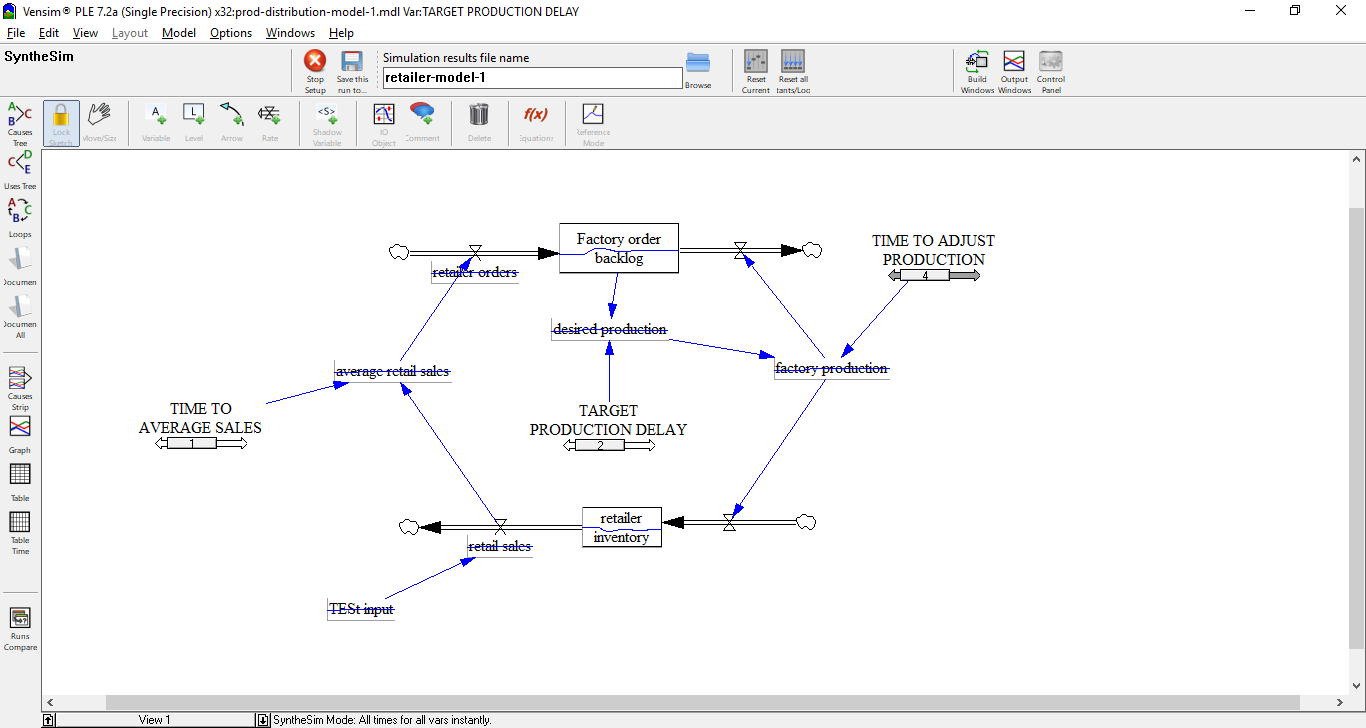

In [2]:
from IPython.display import Image
Image("img/retailer-ordering.png",width=1000,height=1000)

** 1. Read the model & parameters **

In [3]:
model_name = './models/retailer-ordering.mdl'
retailer_model = pysd.read_vensim(model_name)
retailer_model.doc().T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Real Name,FINAL TIME,Factory order backlog,INITIAL TIME,SAVEPER,TARGET PRODUCTION DELAY,TESt input,TIME STEP,TIME TO ADJUST PRODUCTION,TIME TO AVERAGE SALES,average retail sales,desired production,factory production,retail sales,retailer inventory,retailer orders
Py Name,final_time,factory_order_backlog,initial_time,saveper,target_production_delay,test_input,time_step,time_to_adjust_production,time_to_average_sales,average_retail_sales,desired_production,factory_production,retail_sales,retailer_inventory,retailer_orders
Unit,Week,units,Week,Week,weeks,units/Week,Week,weeks,weeks,,units/Week,units/Week,units/Week,units,units/Week
Lims,"(None, None)","(None, None)","(None, None)","(0.0, None)","(None, None)","(None, None)","(0.0, None)","(None, None)","(None, None)","(None, None)","(None, None)","(None, None)","(None, None)","(None, None)","(None, None)"
Type,constant,component,constant,component,constant,component,constant,constant,constant,component,component,component,component,component,component
Eqn,50,"INTEG ( retailer orders-factory production, 200)",0,TIME STEP,2,"100 + STEP(20, 10 )",0.25,4,1,"SMOOTH(retail sales, TIME TO AVERAGE SALES )",Factory order backlog / TARGET PRODUCTION DELAY,"SMOOTH(desired production, TIME TO ADJUST PROD...",TESt input,"INTEG ( factory production-retail sales, 400)",average retail sales
Comment,The final time for the simulation.,,The initial time for the simulation.,The frequency with which output is stored.,,,The time step for the simulation.,,,,,,,,


In [4]:
# Access the variables
print(retailer_model.components.target_production_delay())

2


** 2. Initial Run **

- Imported model is run with no changes to parameters as set in the Vensim model

In [5]:
values = retailer_model.run(params=None, 
                   return_columns=['retail sales','retailer inventory','retailer orders',
                                   'Factory order backlog','TARGET PRODUCTION DELAY','factory production'], 
                   return_timestamps=[0,5,10,15,20,25,30,35,40,45,50], 
                   initial_condition='original', reload=True)

In [6]:
values.head(20)

,Factory order backlog,TARGET PRODUCTION DELAY,factory production,retail sales,retailer inventory,retailer orders
0,200.000000,2,100.000000,100,400.000000,100.000000
5,200.000000,2,100.000000,100,400.000000,100.000000
10,200.000000,2,100.000000,120,400.000000,100.000000
15,261.421022,2,112.736568,120,318.642402,119.936576
20,255.350197,2,126.654865,120,324.650005,119.999799
25,230.759072,2,121.357287,120,349.240929,119.999999
30,236.401848,2,117.635412,120,343.598152,120.000000
35,243.540491,2,119.913991,120,336.459509,120.000000
40,240.637256,2,120.780730,120,339.362744,120.000000
45,238.754735,2,119.910806,120,341.245265,120.000000


Text(0.5, 0, 'Weeks')

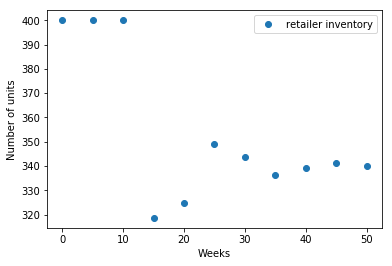

In [7]:
# Plotting values of specific variables
Units = retailer_model.run(return_timestamps=[0,5,10,15,20,25,30,35,40,45,50],
                   return_columns=['retailer inventory'],
                    initial_condition='original', reload=True)
Units.plot(linewidth=0, marker='o')
plt.ylabel('Number of units')
plt.xlabel('Weeks')

** 3. Setting new values to stocks, flows and variables **

- We can set new values to the parameters as we run the model, in the following ways:
- 1) By using a series. Each run of the model will take the successive parameter values as specified in the series
- 2) By using a function to define the parameter values based on certain conditions

In [8]:
# 1. Setting the values using a series
retail_sales_by_week = pd.Series(index=range(retailer_model.components.final_time()), data=range(100,200,2))
values = retailer_model.run(params={'retail sales':retail_sales_by_week},
                            return_columns=['retail sales','retailer inventory','retailer orders',
                                   'Factory order backlog','TARGET PRODUCTION DELAY','factory production'],
                           return_timestamps=[0,5,10,15,20,25,30,35,40,45,50], 
                           initial_condition='original', reload=True)
values.head(20)

,Factory order backlog,TARGET PRODUCTION DELAY,factory production,retail sales,retailer inventory,retailer orders
0,200.000000,2,100.000000,100.0,400.000000,100.000000
5,213.917735,2,101.864240,110.0,378.075922,108.006342
10,246.253893,2,112.465000,120.0,335.746087,118.000020
15,266.934015,2,124.924093,130.0,305.065985,128.000000
20,282.827960,2,134.359815,140.0,279.172040,138.000000
25,303.223095,2,143.645951,150.0,248.776905,148.000000
30,324.497133,2,153.936274,160.0,217.502867,158.000000
35,344.177698,2,164.124526,170.0,187.822302,168.000000
40,363.811914,2,174.002012,180.0,158.188086,178.000000
45,383.970514,2,183.959262,190.0,128.029486,188.000000


In [9]:
#2. Setting new values using a function
def prod_delay_function():
    val = retailer_model.components.factory_order_backlog()
    if val < 250:
        return 2
    elif val < 300:
        return 3
    else:
        return 4
    
values = retailer_model.run(params={'TARGET PRODUCTION DELAY':prod_delay_function},
                            return_columns=['Factory order backlog','TARGET PRODUCTION DELAY','factory production',
                                            'desired production'],
                           return_timestamps=[0,5,10,15,20,25,30,35,40,45,50], 
                           initial_condition='original', reload=True)
values.head(20)

,Factory order backlog,TARGET PRODUCTION DELAY,desired production,factory production
0,200.000000,2,100.000000,100.000000
5,200.000000,2,100.000000,100.000000
10,200.000000,2,100.000000,100.000000
15,265.214853,3,88.404951,103.090987
20,380.434061,4,95.108515,91.915629
25,491.583639,4,122.895910,107.105195
30,515.322061,4,128.830515,122.204621
35,493.493729,4,123.373432,124.912714
40,475.919462,4,118.979865,121.699342
45,474.007735,4,118.501934,119.347299


### 4. Setting values using Machine Learning Predictions

- Let's say that we have collected data on delivery times based on the factory backlog values. Higher the factory backlog orders higher is the time to deliver the material

- We can use machine learning predictions to set the values of "Target Production Delay", which is the variable in our model that signifies target time for delivery of material

- So instead of using the gut feel of the subject matter expert we are using real world data to better inform the model leading to better approximation of the real world

In [10]:
# Load the actual data
prod_target_df = pd.read_csv('production-data-synthetic.csv')
prod_target_df.head(10)

,FactoryBacklog,TargetTime
0,200,2.0
1,250,3.0
2,210,2.2
3,220,2.3
4,300,5.0
5,350,5.0
6,210,2.0
7,180,2.0
8,225,3.0
9,275,4.0


In [11]:
Factors = prod_target_df[['FactoryBacklog']]
Factors.head()

,FactoryBacklog
0,200
1,250
2,210
3,220
4,300


In [12]:
Outcome = prod_target_df['TargetTime']
Outcome.head()

0    2.0
1    3.0
2    2.2
3    2.3
4    5.0
Name: TargetTime, dtype: float64

In [13]:
# Fit the models

from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression

regression_svr = SVR()
regression_linear = LinearRegression()
regression_svr.fit(Factors, Outcome)
regression_linear.fit(Factors, Outcome)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [14]:
print("Linear Regression equation") 
m1 = regression_linear.coef_[0]
b = regression_linear.intercept_
print(' TargetTime = {0} * FactoryBacklog + {1} '.format(m1, b))

Linear Regression equation
 TargetTime = 0.021986364473926656 * FactoryBacklog + -2.2821448313985604 


** Create the function that uses the current value of factory order backlog to generate the prediction for "Target Production Delay" **

In [15]:
def prod_delay_function_ML_Linear():
    val = retailer_model.components.factory_order_backlog()
    prediction = regression_linear.predict(val)[0]
    return prediction

In [16]:
def prod_delay_function_ML_SVR():
    val = retailer_model.components.factory_order_backlog()
    prediction = regression_svr.predict(val)[0]
    return prediction

** Run the model that uses the predictions from Linear Regression **

In [17]:
values_linear = retailer_model.run(params={'TARGET PRODUCTION DELAY':prod_delay_function_ML_Linear},
                            return_columns=['Factory order backlog','TARGET PRODUCTION DELAY','factory production',
                                            'desired production','TIME TO ADJUST PRODUCTION'],
                           return_timestamps=[0,5,10,15,20,25,30,35,40,45,50], 
                           initial_condition='original', reload=True)
values_linear.head(20)

,Factory order backlog,TARGET PRODUCTION DELAY,TIME TO ADJUST PRODUCTION,desired production,factory production
0,200.000000,2.115128,4,94.556922,100.000000
5,213.689110,2.416102,4,88.443752,94.154437
10,263.671264,3.515028,4,75.012571,84.539244
15,453.895018,7.697356,4,58.967649,70.185331
20,731.634294,13.803833,4,53.002255,59.211035
25,1050.708251,20.819110,4,50.468453,53.536350
30,1390.517706,28.290284,4,49.151776,50.714583
35,1740.836325,35.992517,4,48.366618,49.230297
40,2096.891313,43.820872,4,47.851428,48.376027
45,2456.385052,51.724832,4,47.489474,47.836659


** Run the model that uses predictions from Support Vector Regression **

In [18]:
values_svr = retailer_model.run(params={'TARGET PRODUCTION DELAY':prod_delay_function_ML_SVR},
                            return_columns=['Factory order backlog','TARGET PRODUCTION DELAY','factory production',
                                            'desired production','TIME TO ADJUST PRODUCTION'],
                           return_timestamps=[0,5,10,15,20,25,30,35,40,45,50], 
                           initial_condition='original', reload=True)
values_svr.head(20)

,Factory order backlog,TARGET PRODUCTION DELAY,TIME TO ADJUST PRODUCTION,desired production,factory production
0,200.000000,2.100521,4,95.214481,100.000000
5,237.578225,2.933333,4,80.992577,84.740546
10,305.716126,2.933333,4,104.221407,91.088761
15,385.314960,2.933333,4,131.357373,112.016175
20,380.831930,2.933333,4,129.829067,126.953579
25,348.791871,3.165668,4,110.179552,121.240016
30,361.394004,2.933333,4,123.202501,116.991047
35,361.698247,2.933333,4,123.306221,122.070474
40,351.371640,3.085710,4,113.870580,121.260058
45,357.591151,2.933333,4,121.906074,119.714884
